# TRANSFORM (II)

These transformations were performed in parallel with data exploration

0. Import modules
1. Load clean dataframes
2. Merge all dataframes (amz, asos, men and women)


3. **Classify according to "type"** of clothing
4. Filter out **irrelevant types**: "zapatos", "mallas", "falda", "pantalones"
5. Divide **price by pack** when necessary



6. Divide the set in **"complete" and "simple" df versions** to continue with a more deep EDA
**simple_df** will include: `brand, color, type, gender, and price` divided by pack. <br/>

`shop` was excluded because we had **twice as much products from Amazon than ASOS**. <br/>
It was expected since we reached the max limit of requests in the ASOS API. <br/>

### 0. Import modules

In [4]:
# Import modules etc

import pandas as pd
import numpy as np
import re
import random
from unidecode import unidecode
import re

np.random.seed(42)
pd.set_option('display.max_columns', None) # show all the columns

import warnings
warnings.filterwarnings('ignore') # ignorar warnings

from src import dataanalysis_fun1 as eda # Import my module

# plotting
import seaborn as sns  # esta basada en matplotlib
import pylab as plt  # libreria basica para pintar
#import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.rcParams['figure.figsize']=(8, 6)  # tamaño por defecto, decenas de pixeles

%matplotlib inline

### 1. Load clean dataframes

In [5]:
amz_men=pd.read_csv("../data/clean/amz1_men_clothes_clean.csv")
amz_wom=pd.read_csv("../data/clean/amz1_women_clothes_clean.csv")

aso_men=pd.read_csv("../data/clean/asos_men_clothes_clean.csv")
aso_wom=pd.read_csv("../data/clean/asos_women_clothes_clean.csv")

In [6]:
amz_men[["shop", "gender"]]=["amz", "men"]
amz_wom[["shop", "gender"]]=["amz", "women"]
aso_men[["shop", "gender"]]=["asos", "men"]
aso_wom[["shop", "gender"]]=["asos", "women"]

clothes_df=pd.concat([amz_men, amz_wom, aso_men, aso_wom], axis=0, ignore_index=True)
clothes_df=clothes_df.sort_values(by=['brand', "colour", "gender", "price"], ascending=True)

### 2. Classify products according to their description

* Join "ivory" and beige"
* Normalize categories to English
* Drop Nas in coloir column

In [7]:
colors_transl = {
    'marfil': 'beige',
    'marron': 'brown',
    'rojo': 'red',
    'amarillo': 'yellow',
    'azul': 'blue',
    'beis': 'beige',
    'blanco': 'white',
    'gris': 'gray',
    'morado': 'purple',
    'multicolor': 'multicolor',
    'naranja': 'orange',
    'negro': 'black',
    'rosa': 'pink',
    'verde': 'green',
    'turquesa': 'turquoise',
    'dorado': 'gold'
}

clothes_df['colour'] = clothes_df['colour'].map(colors_transl)
clothes_df = clothes_df.dropna(subset=["colour"])

In [8]:
type_dict={"tshirt":["camiseta", "shirt", "polo", "Camicetta", "manga larga", "camisola", "manica lunga"],
           "top": ["top"],
           "jacket":["Cazadora", "casaca", "chaqueta", "Jacket", "Poncho", "Abrigo"],
           "sweatshirt":["Hoodie","sudadera","polar","Hoody", "Sweater", "Sueter", "Suter", "chaleco"],
           "sweater":["jersey","jersei", "pulover", "pullover", "cardigan", "Jumper"],
           "dress":["vestido", "tunica", "camison"],
           "shirt": ["camisa", "blusa", "blouse", "bluse"],
           "underwear":["lenceria", "sujetador", "corse", "interior", "Sock"],
           "pants": ["pantalones",  "jeans", "vaqueros"],
           "leggings": [ "legging", "mallas", "jogger", "mallot", "leotardo"],
           "skirt": [ "falda"],
           "shoes": [ "zapatos"]
          }

In [9]:
def remove_plural_last_word(text):
    '''
    Modify description to improve key word match (take out the last s in plural words)
    '''
    words = text.split()
    # Check if the last word in the phrase ends with 's'
    if words and words[-1].lower().endswith('s'):
        # Remove the last word
        return ' '.join(words[:-1])
    return text


clothes_df["description2"]=[remove_plural_last_word(unidecode(des.lower())) for des in clothes_df["description"]]
clothes_df["description2"].sample(2)

39053    camiseta roja sin mangas con espalda de nadado...
27501    camiseta azul a rayas con cuello redondo de pi...
Name: description2, dtype: object

In [10]:
def check_key_terms(dataframe, colnam, key_terms):
    '''
    Eval if any of the keywords is present in the description
    '''
    results = pd.DataFrame()
    for term in key_terms:
        results[term] = dataframe[colnam].str.contains(term.lower())
    output = results.any(axis=1)  # Check if any key term is present in a row
    return output


for key, value in type_dict.items():
    key_terms_results = check_key_terms(clothes_df,"description2", value)
    clothes_df.loc[key_terms_results, 'type']=key

In [11]:
display(clothes_df.value_counts("type"))
sum(clothes_df["type"].isna())

type
tshirt        8525
shirt         7797
sweatshirt    7640
dress         7372
sweater       3616
top           2833
underwear      407
jacket         392
pants          154
skirt          144
leggings        23
shoes            6
dtype: int64

357

#### Filter out "shoes", "leggings", "skirt", "pants", "jacket", "underwear", and drop NAs

In [12]:
clothes_df = clothes_df[~clothes_df["type"].isin(["", "shoes", "leggings", "skirt", "pants", "jacket", "underwear"])]
clothes_df = clothes_df.dropna(subset=["type"])

In [13]:
display(clothes_df.value_counts("type"))
sum(clothes_df["type"].isna())

type
tshirt        8525
shirt         7797
sweatshirt    7640
dress         7372
sweater       3616
top           2833
dtype: int64

0

### 3.  Divide price of Packs

There are 2 rows including the term "pack" but actually being only a single product.<br/>
These have a price_pack = 0, what returns and inf. Thus, Manually modify them to original price.

In [14]:
pack_dict={"pack":["pack", "packs"]}

def subset_pack(x):
    x = x.lower()
    x=unidecode(x)
    theval=1
    for KKK, VVV in pack_dict.items():
        for VAL in VVV:
            if VAL.lower() in x: # the item is actually a pack
                #find the number of elements and divide the price
                digits_list = re.findall(r'\b\d\b', x)

                numeric_values = [int(digit) for digit in digits_list]
                if numeric_values:
                    theval = min(numeric_values)
                    #if theval == 0:
                    #    print(digits_only, x)
                else:
                    theval=1

    return theval

##

clothes_df["price_pack"]=clothes_df['description'].apply(subset_pack)

zeroval=clothes_df["price_pack"]==0
clothes_df.loc[zeroval, 'price_pack'] = 1
clothes_df["price_pack"]=clothes_df["price"]/clothes_df["price_pack"]
nan_inf_mask = clothes_df["price_pack"].isin([np.nan, np.inf, -np.inf])

### 4. Remove brand names with less than 10 products --> "other"

1874 brand have less than 10 products, <br/>
616 brands have more or 10 products

In [15]:
frec_df=pd.DataFrame(clothes_df["brand"].value_counts())
frec_df["brand"].describe()
lowfreq_brands=frec_df["brand"][frec_df["brand"]<10].index
highfreq_brands=frec_df["brand"][frec_df["brand"]>=10].index
clothes_df["brand"][clothes_df["brand"].isin(lowfreq_brands)]="other"

## Decisions maked after EDA analysis:
### 5. Divide brands in 3 groups according to their average price

In [16]:
brand_price_col_df=clothes_df.pivot_table(columns="colour", index="brand", aggfunc="size", fill_value=0)
brand_price_col_df["mean_price"]=clothes_df.groupby("brand").mean()["price_pack"]

cut_param="mean_price"
A=list(brand_price_col_df[brand_price_col_df[cut_param]<26].index)
B=list(brand_price_col_df[(brand_price_col_df[cut_param]>=26)&(brand_price_col_df[cut_param]<35)].index)
C=list(brand_price_col_df[brand_price_col_df[cut_param]>=35].index)

brand_price_col_df=brand_price_col_df.sort_values(cut_param)

In [17]:
clothes_df=clothes_df.copy()

clothes_df["brand_class"]=0
clothes_df["brand_class"][clothes_df["brand"].isin(A)]="low"
clothes_df["brand_class"][clothes_df["brand"].isin(B)]="middle"
clothes_df["brand_class"][clothes_df["brand"].isin(C)]="high"
clothes_df["brand_class"].value_counts()

low       16498
middle    13478
high       7807
Name: brand_class, dtype: int64

In [18]:
clothes_df.head()

,brand,description,price,colour,shop,gender,description2,type,price_pack,brand_class
7792,other,SDBrice LS2 - Jersey de punto fino para hombre...,36.19,beige,amz,men,sdbrice ls2 - jersey de punto fino para hombre...,sweater,36.19,middle
7966,other,SDGibril - Jersey - 21107899,45.40,beige,amz,men,sdgibril - jersey - 21107899,sweater,45.40,middle
8187,other,SDElijah 21107501 - Jersey de punto grueso par...,49.94,beige,amz,men,sdelijah 21107501 - jersey de punto grueso par...,sweater,49.94,middle
8166,other,SDLenz Zipper SW - Sudadera - 21107421,62.44,beige,amz,men,sdlenz zipper sw - sudadera - 21107421,sweatshirt,62.44,middle
3064,other,Norwin Jersey De Punto Troyer Suéter Sudadera ...,62.44,brown,amz,men,norwin jersey de punto troyer sueter sudadera ...,sweater,62.44,middle


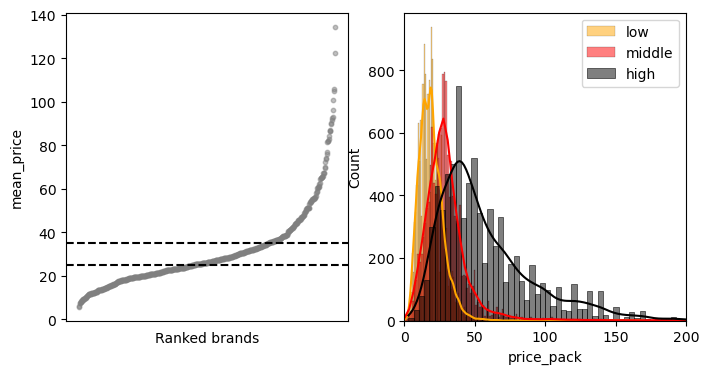

In [19]:
plt.rcParams['figure.figsize'] = (8, 4)

custom_palette = {'low': 'orange', 'middle': 'red', 'high': 'black'}

# Crear una figura con dos ejes (subplots)
fig, axes = plt.subplots(1, 2)

# Gráfico con regplot en el primer eje (izquierda)
sns.regplot(x=brand_price_col_df.index, y=brand_price_col_df[cut_param],
            scatter_kws={"s": 10, "alpha": 0.5, "color": "grey"},
            fit_reg=False, ax=axes[0])

axes[0].set_xticks([]) 
axes[0].set_xlabel('Ranked brands')
axes[0].set_ylabel(cut_param)
axes[0].axhline(y=25, color='black', linestyle='--')  
axes[0].axhline(y=35, color='black', linestyle='--') 


####

sns.histplot(data=clothes_df[clothes_df["brand_class"]=="low"], x="price_pack", color="orange", label="low", kde=True, ax=axes[1]).set_xlim(0, 200)
sns.histplot(data=clothes_df[clothes_df["brand_class"]=="middle"],x="price_pack", color="red", label="middle", kde=True, ax=axes[1]).set_xlim(0, 200)
sns.histplot(data=clothes_df[clothes_df["brand_class"]=="high"], x="price_pack", color="black", label="high", kde=True, ax=axes[1]).set_xlim(0, 200)

axes[1].legend();


### 8. Get dummy variables to construct a machine learning model

In [20]:
clothes_df=clothes_df.reset_index(drop=True)

In [21]:
clothes_dum = clothes_df[["gender", "type", "colour", "brand_class", "price_pack"]]
dum_vars=["gender", "type", "colour", "brand_class"]

for col_dum in dum_vars:
    dummies_temp = pd.get_dummies(clothes_dum[col_dum], drop_first=True)
    clothes_dum = pd.concat([clothes_dum, dummies_temp], axis=1) # Concatenate the dummies 
    clothes_dum.drop(col_dum, axis=1, inplace=True) # Drop the original column 

display(clothes_dum.columns)
clothes_dum.head()

Index(['price_pack', 'women', 'shirt', 'sweater', 'sweatshirt', 'top',
       'tshirt', 'black', 'blue', 'brown', 'gold', 'gray', 'green',
       'multicolor', 'orange', 'pink', 'purple', 'red', 'turquoise', 'white',
       'yellow', 'low', 'middle'],
      dtype='object')

,price_pack,women,shirt,sweater,sweatshirt,top,tshirt,black,blue,brown,gold,gray,green,multicolor,orange,pink,purple,red,turquoise,white,yellow,low,middle
0,36.19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,45.40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,49.94,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,62.44,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,62.44,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


## 3. Save `clothes` dataframe [dummies, simple, complete]
The lines are commented to avoid overwriting

In [22]:
clothes_complete=clothes_df.copy()
clothes_complete["product_id"]=clothes_complete.index+1
clothes_simple=clothes_complete[["product_id", "brand_class", "colour", "gender", "type", "price_pack"]]

In [221]:
clothes_simple.head()

,product_id,brand_class,colour,gender,type,price_pack
0,1,middle,beige,men,sweater,36.19
1,2,middle,beige,men,sweater,45.40
2,3,middle,beige,men,sweater,49.94
3,4,middle,beige,men,sweatshirt,62.44
4,5,middle,brown,men,sweater,62.44


In [23]:
#clothes_simple.to_csv('../data/clean/clothes_simple.csv', index=False)
#clothes_complete.to_csv('../data/clean/clothes_complete.csv', index=False)
#clothes_dum.to_csv('../data/clean/clothes_dum.csv', index=False)

#clothes_simple.to_excel('../data/clean/clothes_simple.xlsx', index=False) 
#clothes_complete.to_excel('../data/clean/clothes_complete.xlsx', index=False) 